In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft
from scipy.linalg import toeplitz
import pandas as pd

Question 1

(a)

From the lecture notes, we know that the spectral densities for $MA(q)$, $AR(p)$ and $ARMA(p,q)$ processes are 
\begin{align*}
S_{MA}(f) &= \sigma_{\varepsilon}^2 |1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2\\
S_{AR}(f) &= \frac{\sigma_{\varepsilon}^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}\\
S_{ARMA}(f) &= \sigma_{\varepsilon}^2\frac{|1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}.
\end{align*}
Note that the third formula can be used for all cases in our function. So if we have an $MA(q)$ process, then in our function the phis list will be empty and the denominator will be $|1|^2 = 1$ resulting in the formula for the $S_{MA}(f)$.
Below, for each element in f we first calculate the transfer functions $G_{\phi}(f[i])$ and $G_{\theta}(f[i])$ and then we determine the sdf evaluated at $f[i]$.

In [2]:
def S_ARMA(f, phis, thetas, sigma2):
    """Input: 
    f: list of frequences at which it should be evaluated (must be in the interval [1/2, 1/2))
    phis: the list [phi_{1,p},..., phi_{p,p}]
    thetas: the list [theta_{1,q},..., theta_{q,q}]
    sigma2: a scalar for the variance of the white noise
    Output:
    S: theoretical spectral density function for a ARMA(p,q) process evaluated for each element in f."""

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize sdf to be zero everywhere
    S = np.zeros(len(f))
    
    # for each element in f, evaluate the sdf
    for i in range(len(f)):            
        # initialize the two sums
        G_theta = 1
        G_phi = 1

        # G_phi = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
        for m in range(p):
            G_phi = G_phi - phis[m]*np.e**(-1j*2*np.pi*f[i]*(m+1))
        
        # G_theta = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
        for n in range(q):
            G_theta = G_theta - thetas[n]*np.e**(-1j*2*np.pi*f[i]*(n+1))

        # update the ith element of S
        S[i] = sigma2*(abs(G_theta))**2/(abs(G_phi))**2
 
    return S

(b)

We now simulate a Gaussian $ARMA(2,2)$ process of length $N$ given by
\begin{equation*}
X_t = \phi_{1,2}X_{t-1} + \phi_{2,2}X_{t-2} + \epsilon_t - \theta_{1,2}\epsilon_{t-1} - \theta_{2,2}\epsilon_{t-2}, \quad t>2.
\end{equation*}

In [29]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """Input:
    phis: the list [phi_{1,2}, phi_{2,2}]
    thetas: the list [theta_{1,2}, theta_{2,2}]
    sigma2: a scalar for the variance of the white noise
    N: length of simulated process
    Output: 
    Time series of length N simulated by the ARMA(2,2) process."""
    
    # initialize list recording the values of the stochastic process
    X = np.zeros(N+100)

    # create an array with N + 100 epsilons following normal distribution with mean 0 and variance sigma2
    epsilons = np.random.normal(0,np.sqrt(sigma2), N+100)

    # recursively update the values Xt
    for i in range(2,N+100):
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + epsilons[i] - thetas[0]*epsilons[i-1] - thetas[1]*epsilons[i-2]
        
    # return an array with only the N values after the first 100
    return X[-N:]

(c)

The Fast Fourier Transform algorithm $fft(X)$ takes our $N$ dimensional time series and outputs an $N$ dimensional list $y$, where
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
This is similar to the fourier transform we need for computing the periodogram, which is given by
\begin{equation*}
\sum_{t = 1}^{N} X_t e^{-i2\pi f_k t}.
\end{equation*}
Noting that python counts from 0 instead of 1, we can transform this into 
\begin{equation*}
\sum_{t = 0}^{N-1} X[t] e^{-i2\pi f_k (t+1)} = y[k]e^{-i 2\pi f_k},
\end{equation*}
i.e., after obtaining the $y[k]$ using the fft method, we need to multiply each element by $e^{-i 2\pi f_k}$. Our estimate of the sdf is then
\begin{equation*}
S[k] = \frac{1}{N} \big| y[k]e^{-i 2\pi f_k} \big|^2 = \frac{1}{N} \big| fft(X) e^{-i 2\pi f_k} \big|^2
\end{equation*}

We have obtained our estimate for the sdf for the Fourier frequencies $f_k$ which range from $0$ to $(N-1)/N$. We note that in the lectures notes we define the periodogram over $[-1/2, 1/2)$. Using the fact that the sdf is periodic, we can obtain $\hat{S}^p(f_k)$ by using $fftshift$, i.e. rearranging the frequencies so that the N Fourier frequencies lie in the interval $[-1/2, 1/2)$. This will be done later when creating plots.

In [33]:
def periodogram(X):
    """Input:
    X: numpy array of the time series
    Output:
    The periodogram at the Fourier frequencies for X."""
    
    N = len(X)

    # Fourier frequencies
    f_k = np.arange(0,N)/N
    
    # compute the periodogram using the method described above
    S = abs(fft(X)*(np.exp(-1j*2*np.pi*f_k)))**2/N

    return S

We now compute the direct spectrail estimate at the Fourier frequencies using a $p \times 100 \%$ cosine taper. We use the taper from the lecture notes (with slight adaptation since python counts from 0).

We want to calculate 
\begin{equation*}
\sum_{t = 1}^N h_tX_te^{i2\pi f t} \quad \text{or since python counts from 0} \quad \sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)}
\end{equation*}
Once again, since the $fft$ algorithm computes
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} h[n]X[n] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
So we need to multiply by $e^{-i2 \pi f_k}$:
\begin{equation*}
\sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)} = y[k] e^{-i2 \pi f_k}
\end{equation*}
Now we can compute the direct spectral estimator
\begin{equation*}
S[k] = \big| y[k] e^{-i2 \pi f_k} \big|^2 = \big| fft(h X) e^{-i2 \pi f_k} \big|^2
\end{equation*}
Once again, we note that we have obtained the direct spectral estimate over the domain $[0,1)$. Later when plotting we will need to use the fftshift function so that the domain is $[-1/2, 1/2)$ as defined in the lecture notes.

In [5]:
def direct(X,p):
    """
    Input:
    X: time series
    p: variable for cosine taper
    Output:
    Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X."""
    
    N = len(X)

    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(p*(N))/2)]
    interval2 = interval[int(np.floor(p*(N))/2): N - int(np.floor(p*N)/2)]
    interval3 = interval[N - int(np.floor(p*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(p*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(p*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))

    # Fourier frequencies
    f_k = interval/N

    # compute the directral spectral estimator as described above
    S = abs(fft(h*X)*(np.exp(-1j*2*np.pi*f_k)))**2

    return S

(d)

A.

We have that $r = 0.8$ and $f' = 12/128$. Using results from the lecture notes (page 51), we have that
\begin{equation*}
\phi_{1,2} = 2r \cos (2 \pi f') \quad \phi_{2,2} = -r^2.
\end{equation*}

<class 'numpy.ndarray'>


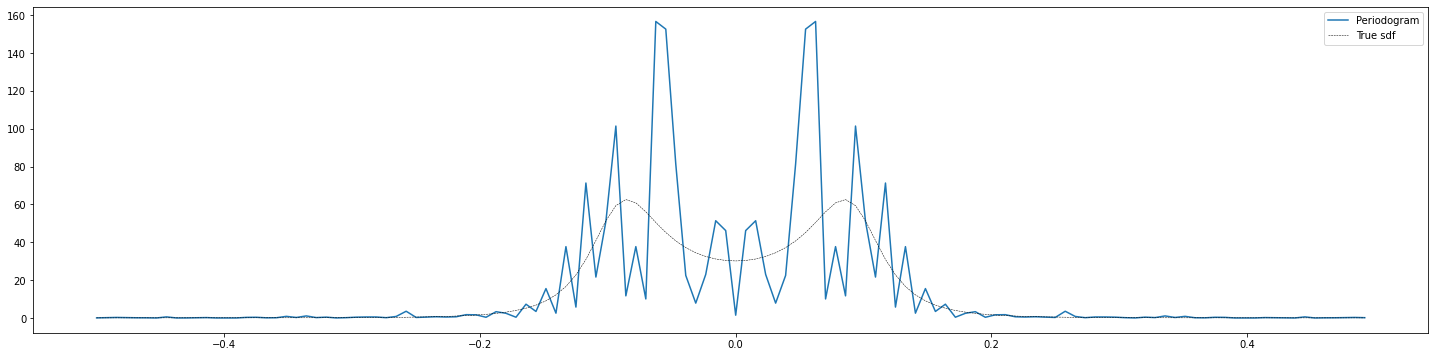

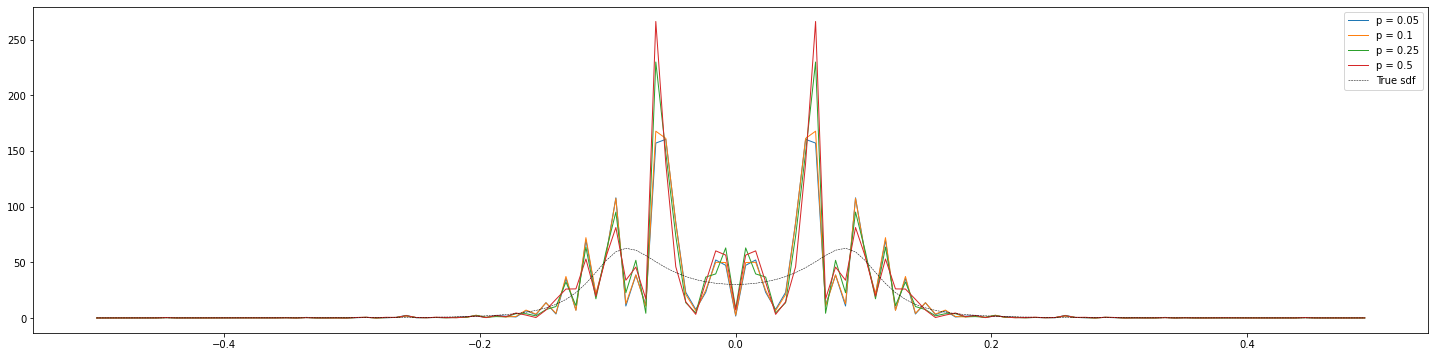

In [32]:
# parameters
r = 0.8
f = 12/128
phi_1 = 2*r*np.cos(2*np.pi*f)
phi_2 = -r**2

X = ARMA22_sim([phi_1, phi_2], [-0.5,-0.2], 1, 128)

# frequencies over [-1/2, 1/2)]
freq = t = np.arange(-64, 64)/128

# periodogram
plt.figure(figsize=(25, 6))
plt.plot(freq, fftshift(periodogram(X)), label = "Periodogram")
plt.plot(freq, S_ARMA(freq, [phi_1, phi_2], [-0.5,-0.2], 1), "k--", linewidth = 0.5, label = "True sdf")  # true sdf
plt.legend()
plt.show()

# direct
plt.figure(figsize=(25, 6))
for p in [0.05, 0.1, 0.25, 0.5]:
    plt.plot(freq, fftshift(direct(X, p)), linewidth = 1,label = f"p = {p}")
plt.plot(freq, S_ARMA(freq, [phi_1, phi_2], [-0.5,-0.2], 1), "k--", linewidth = 0.5, label = "True sdf")  # true sdf
plt.legend()
plt.show()

In [38]:
def func(r):

    r = 0.8

    phi_1 = 2*r*np.cos(2*np.pi*12/128)
    phi_2 = -r**2

    periodogram_frequencies = []
    direct_p1_frequencies = []
    direct_p2_frequencies = []
    direct_p3_frequencies = []
    direct_p4_frequencies = []


    for i in range(10000):
        X = ARMA22_sim([phi_1, phi_2], [-0.5,-0.2], 1, 128)
        periodogram_frequencies.append(periodogram(X)[[12,32,60]])
        direct_p1_frequencies.append(direct(X, 0.05)[[12,32,60]])
        direct_p2_frequencies.append(direct(X, 0.1)[[12,32,60]])
        direct_p3_frequencies.append(direct(X, 0.25)[[12,32,60]])
        direct_p4_frequencies.append(direct(X, 0.5)[[12,32,60]])

    return periodogram_frequencies, direct_p1_frequencies, direct_p2_frequencies, direct_p3_frequencies, direct_p4_frequencies

In [8]:
for i in range(3):
    s = 0
    for j in range(10000):
        s += periodogram_frequencies[j][i]
    print(s/10000)

for i in range(3):
    s = 0
    for j in range(10000):
        s += direct_p1_frequencies[j][i]
    print(s/10000)

for i in range(3):
    s = 0
    for j in range(10000):
        s += direct_p2_frequencies[j][i]
    print(s/10000)

for i in range(3):
    s = 0
    for j in range(10000):
        s += direct_p3_frequencies[j][i]
    print(s/10000)

for i in range(3):
    s = 0
    for j in range(10000):
        s += direct_p4_frequencies[j][i]
    print(s/10000)

57.273077765612605
0.6160716618530072
0.10933893405984034
57.50409115577816
0.5340104934067654
0.05646865274657431
57.697253853200564
0.4980157870302568
0.05583254736842644
58.28859631087837
0.47828823728769504
0.05558349679121288
58.63870767325244
0.4720278017122381
0.05562328223563107


In [9]:
for f in [12/128, 32/128, 60/128]:
    print(S_ARMA([f], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1))

[59.37582589]
[0.46856044]
[0.05584653]


In [37]:
for r in np.arange(81,100)/100:
    freq = func(r)

Question 2

(a)

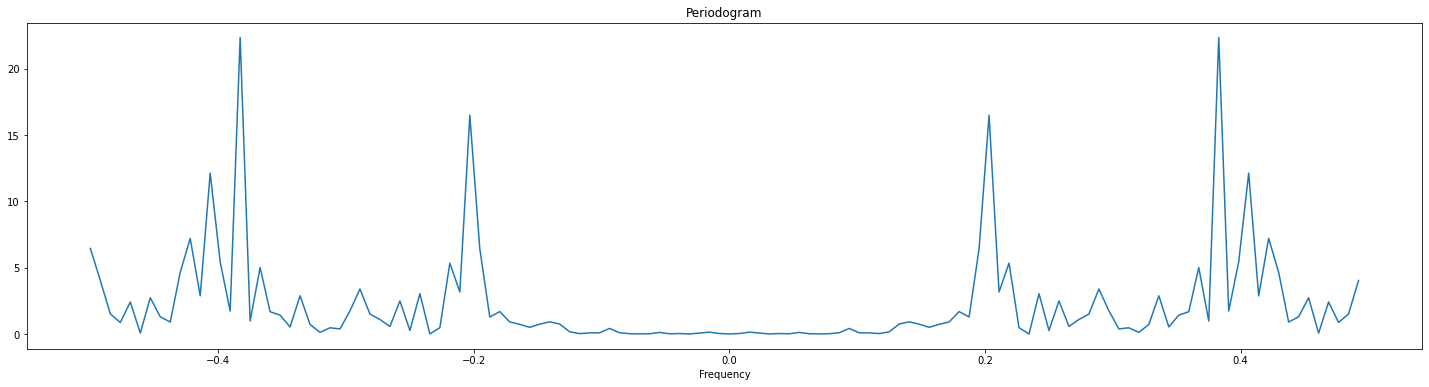

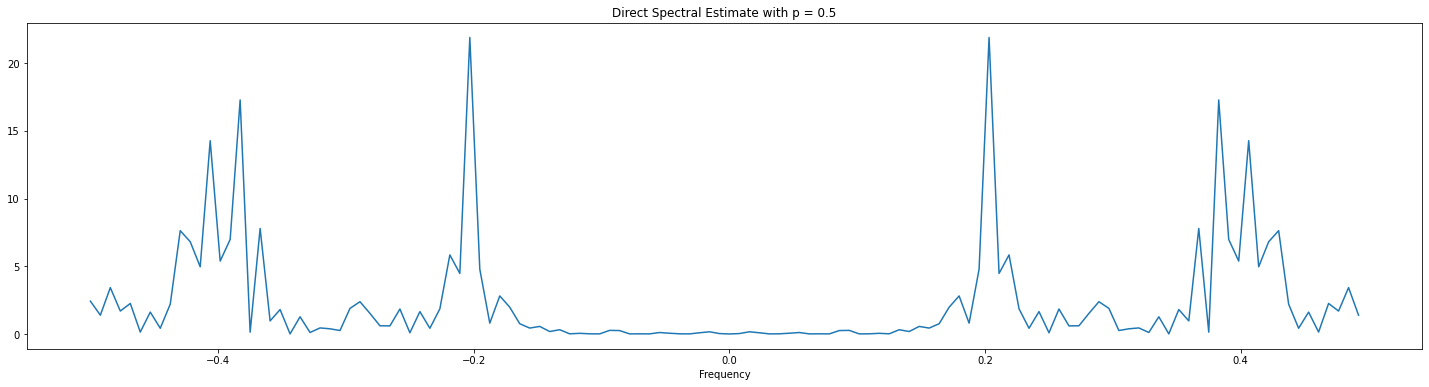

In [11]:
# read in the data
from numpy import genfromtxt
data = list(genfromtxt('88.csv', delimiter=','))

N = len(data)

# array over the range [-1/2, 1/2) with N values
t = np.arange(-N/2, N/2)/N

# plot the periodogram
plt.figure(figsize=(25, 6))
plt.plot(t, fftshift(periodogram(data)))  # we use fftshift so that the range is [-1/2, 1/2)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.show()

# plot the direct spectral estimate for p = 0.5
plt.figure(figsize=(25, 6))
plt.plot(t, fftshift(direct(data, p = 0.5)))
plt.title("Direct Spectral Estimate with p = 0.5")
plt.xlabel("Frequency")
plt.show()

(b)

First we create a function that fits an $AR(p)$ model using the untapered Yule-Walker method. Using the results derived in the lecture notes, we have that 
\begin{equation*}
\hat{\phi}_p = \hat{\Gamma}^{-1}\hat{\gamma}_p \quad \text{ and } \quad \hat{\sigma}^2_p = \hat{s}_0 - \sum_{j=1}^p \hat{\phi}_{i,p} \hat{s}_j,
\end{equation*}
where $\hat{\phi}_p = [\hat{\phi}_{1,p}, \dots, \hat{\phi}_{p,p}]^T$, $\hat{\gamma}_p = [\hat{s}_1, \dots, \hat{s}_p]^T$ and $\hat{\Gamma}_p$ is the Toeplitz matrix as descibed in the notes. We also have that
\begin{equation*}
\hat{s}_\tau = \frac{1}{N} \sum_{t=0}^{N - |\tau| - 1}X_t X_{t + |\tau|}
\end{equation*}
Below we first calculate $s_\tau$ for $\tau = 0, 1, ..., p$ and then find the estimates $\hat{\phi}_p$ and $\hat{\sigma}^2_p$. From these we can then compute the esimate of the sdf using our S_ARMA function from question 1.

In [12]:
def YW(X, p):
    """Input:
    X: Time series data.
    p: parameter of the AR(p) model we fit.
    Output:
    phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] for the AR(p) model
    sigma2: estimated variance of the white noise. """
    N = len(X)

    # initialize array that will contain s_0, s_1, ..., s_p
    s = np.zeros(p+1)

    for i in range(p+1):

        # calculate s_i
        for t in range(N-i):
            s[i] += X[t]*X[t+i]/N

    # construct the matrix Gamma and the vector gamma
    Gamma = toeplitz(s[0:p])
    gamma = s[1:]

    # calculate phis
    phis = np.dot(np.linalg.inv(Gamma), gamma)

    # compute the estimated variance
    sigma2 = s[0] - np.dot(phis, s[1:])
    
    return phis, sigma2

Now we fit a $50$% cosine tapered Yule-Walker model. The steps are almost identical to the previous part, except that our autocovariance sequence is
\begin{equation*}
\hat{s}_\tau = \sum_{t = 0}^{N - |\tau| - 1} h_t X_t h_{t + |\tau|}X_{t + |\tau|}.
\end{equation*}

In [13]:
def YW_tapered(X,p):
    """Input:
    X: Time series data
    p: parameter of the AR(p) model
    Output:
    phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] for the 50% cosine tapered AR(p) model
    sigma2: estimated variance of the white noise."""
    
    N = len(X)

    # compute the 50% cosine taper h
    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(0.5*(N))/2)]
    interval2 = interval[int(np.floor(0.5*(N))/2): N - int(np.floor(0.5*N)/2)]
    interval3 = interval[N - int(np.floor(0.5*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(0.5*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(0.5*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))

    # initialize array that will contain s_0, s_1, ..., s_p
    s = np.zeros(p+1)

    for i in range(p+1):

        # calculate s_i
        for t in range(N-i):
            s[i] += h[t]*X[t]*h[t+i]*X[t+i]
    
    # construct the matrix Gamma and the vector gamma
    Gamma = toeplitz(s[0:p])
    gamma = s[1:]

    # calculate phis
    phis = np.dot(np.linalg.inv(Gamma), gamma)

    # compute the estimated variance
    sigma2 = s[0] - np.dot(phis, s[1:])
    
    return phis, sigma2

We now approximate solution from the maximum likelihood method as described in the notes. We have the following estimates:
\begin{equation*}
\hat{\phi} = (F^TF)^{-1} F^T X, \quad \hat{\sigma}^2_{\epsilon} = \frac{(X - F\hat{\phi})^T(X - F\hat{\phi})}{N-p}
\end{equation*}
From these we can then compute the esimate of the sdf using our S_ARMA function from question 1.

In [14]:
def max_likelihood(X,p):
    """Input:
    X: Time series data
    p: parameter of the AR(p) model
    Output:
    phis: estimated parameters [phi_{1,p}, ..., phi_{p,p}] using the maximum likelihood mehtod
    sigma2: estimated variance of the white noise."""

    N = len(X)

    
    F = []
    for i in range(N-p):
        F.append(np.flip([X[j] for j in range(i,i+p)]))

    X = X[p:]

    #phis = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(F),F)), np.transpose(F)), X)
    phis = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@X
    
    sigma2 = np.dot(np.transpose(X - np.dot(F, phis)), (X - np.dot(F, phis)))/(N-p)
    
    return phis, sigma2

We create three plots that illustrate the estimated sdf for different values of $p$ for each of the three methods. We can see that as $p$ increases the estimated sdf in each case becomes more similar to the periodogram. For large values of $p$ however, this may cause overfitting. This is why in the next section we consider the Akaike information criterion.

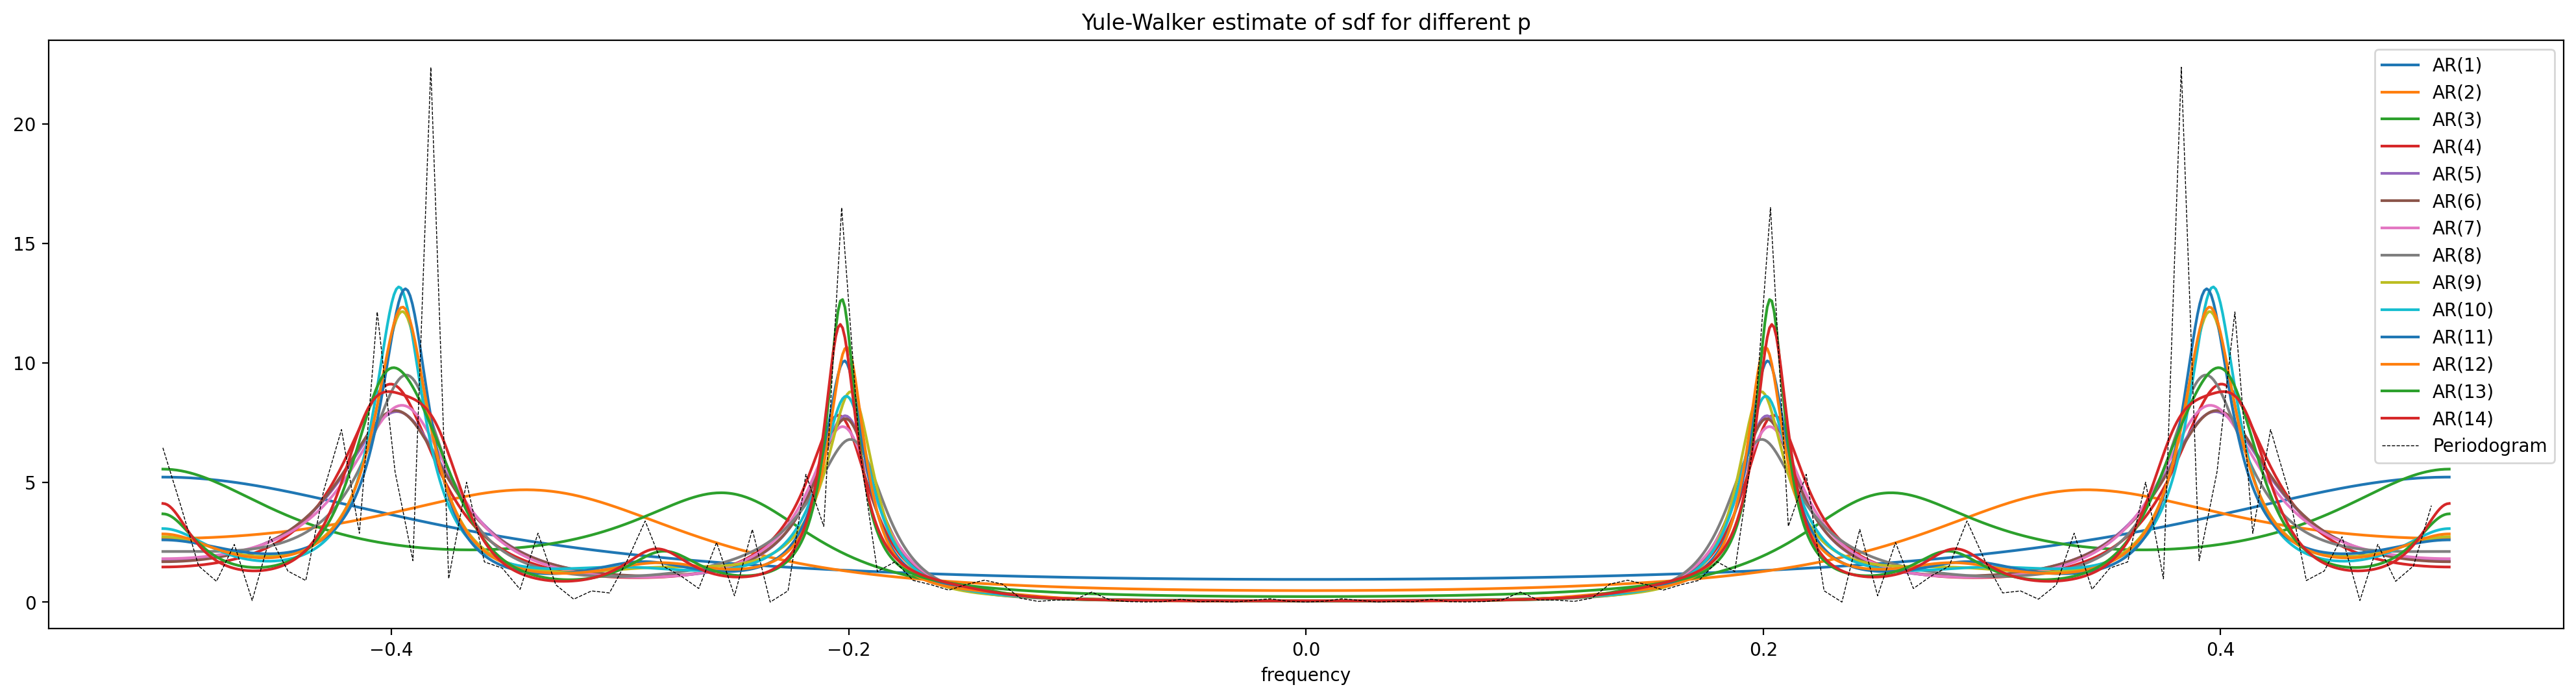

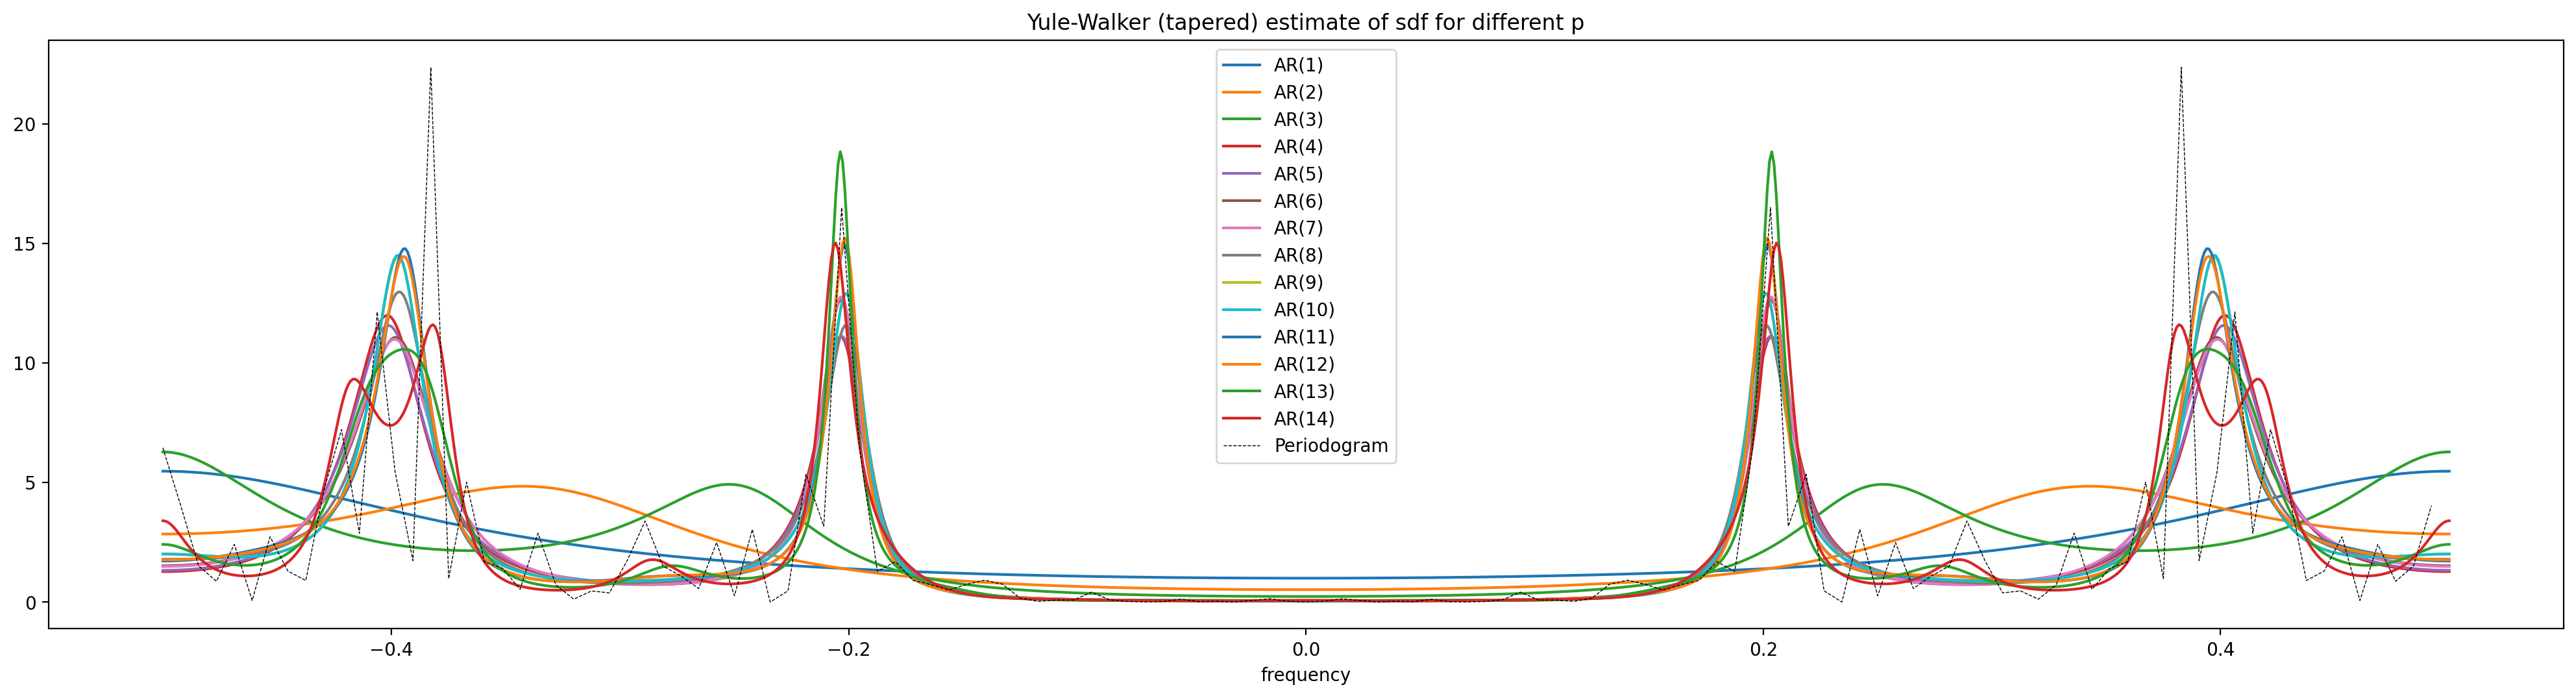

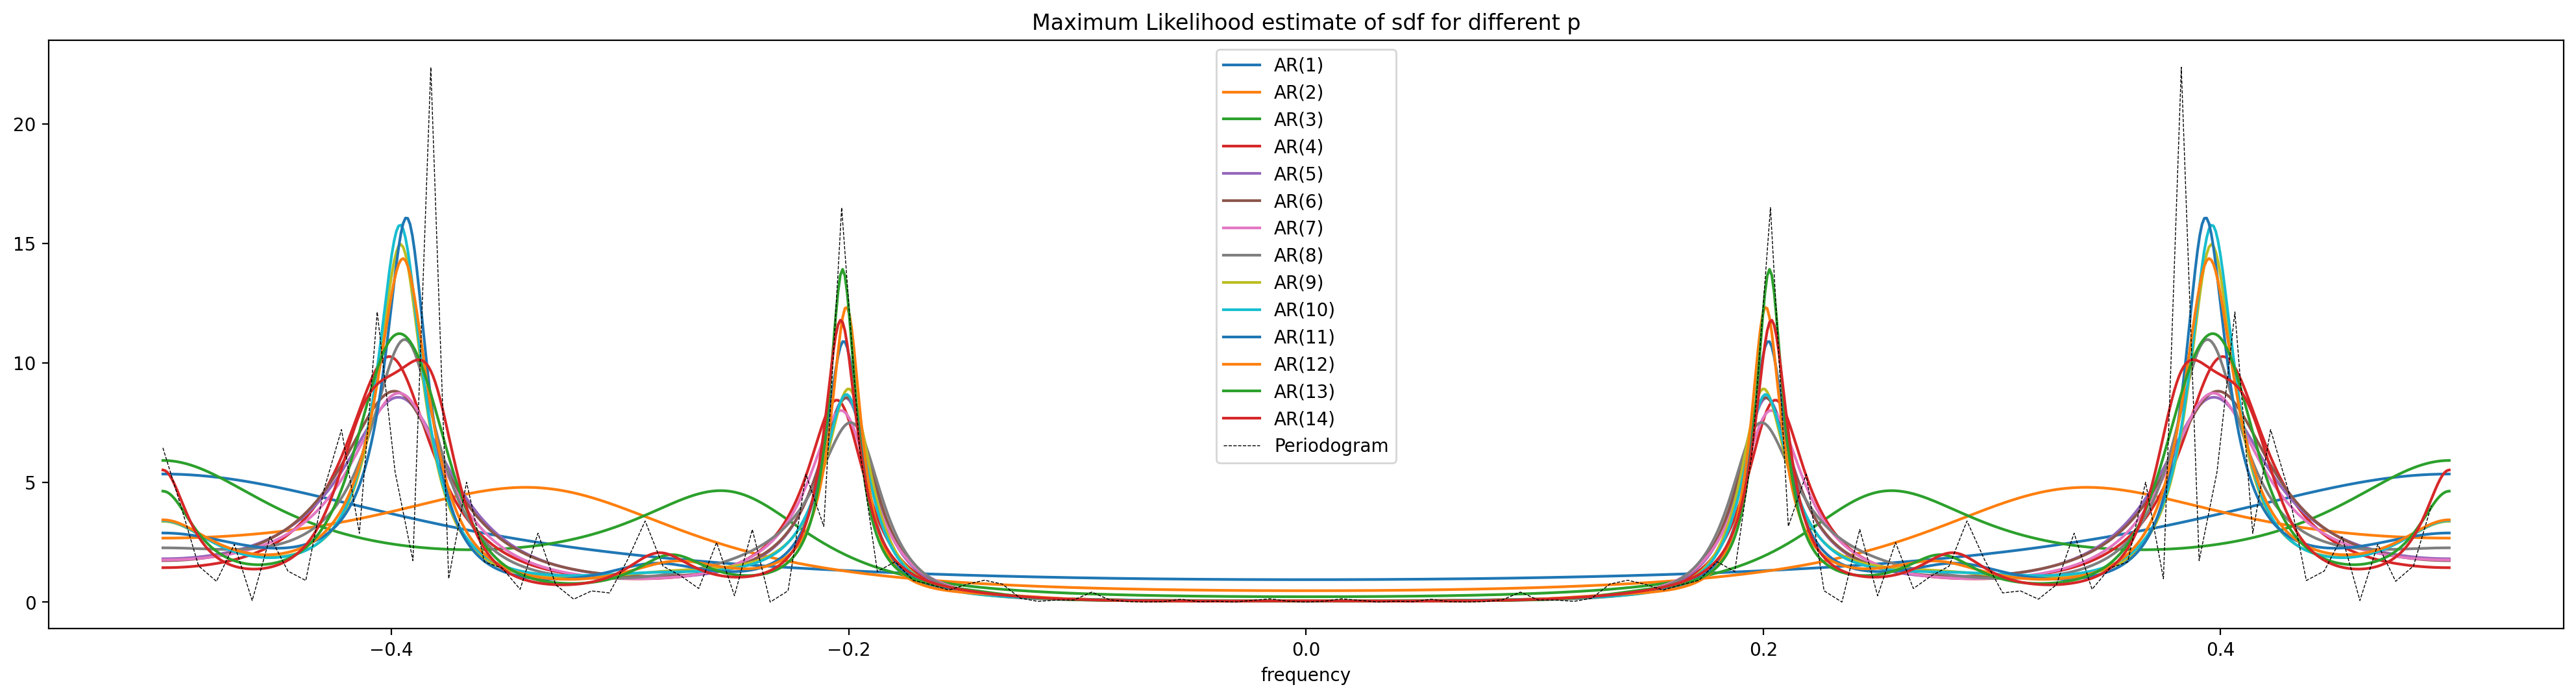

In [15]:
f = np.arange(-N/2, N/2)/N  # shifter Fourier frequencies
t = np.linspace(-1/2, 1/2, 1000)

# YW estimation plot
plt.figure(figsize=(25, 6), dpi = 200)

# plot YW sdf for p = 1,...,21
for p in range(1,15):
    plt.plot(t, S_ARMA(t, YW(data, p)[0], [], YW(data, p)[1]), label = f"AR({p})")
plt.plot(f, fftshift(periodogram(data)), "k--", linewidth = 0.5, label = "Periodogram")
plt.title("Yule-Walker estimate of sdf for different p")
plt.xlabel("frequency")
plt.legend()
plt.show()

# YW_tapered estimation plot
plt.figure(figsize=(25, 6), dpi = 200)
for p in range(1,15):
    plt.plot(t, S_ARMA(t, YW_tapered(data, p)[0], [], YW_tapered(data, p)[1]), label = f"AR({p})")
plt.plot(f, fftshift(periodogram(data)), "k--", linewidth = 0.5, label = "Periodogram")
plt.title("Yule-Walker (tapered) estimate of sdf for different p")
plt.xlabel("frequency")
plt.legend()
plt.show()

# Maximum Likelihood estimation plot
plt.figure(figsize=(25, 6), dpi = 200)
for p in range(1,15):
    plt.plot(t, S_ARMA(t, max_likelihood(data, p)[0], [], max_likelihood(data, p)[1]), label = f"AR({p})")
plt.plot(f, fftshift(periodogram(data)), "k--", linewidth = 0.5, label = "Periodogram")
plt.title("Maximum Likelihood estimate of sdf for different p")
plt.xlabel("frequency")
plt.legend()
plt.show()

(c)

In [16]:
def AIC(p, N, sigma2):
    """Input:
    p: parameter of AR(p) model
    N: number of elements of data series
    sigma2: estimated variance of the white noise of the process
    Output:
    The AIC of the fitted model."""

    return 2*p + N*np.log(sigma2)


# initialize lists that will contain the AIC values for p = 1,...,20
YW_AIC = []
YW_tapered_AIC = []
max_likelihood_AIC = []

# compute the AIC for each p and each model
for p in np.arange(1,21):
    YW_AIC.append(AIC(p, len(data), YW(data, p)[1]))
    YW_tapered_AIC.append(AIC(p, len(data), YW_tapered(data, p)[1]))
    max_likelihood_AIC.append(AIC(p, len(data), max_likelihood(data, p)[1]))

# create table
header = ["p","Yule-Walker", "Yule-Walker tapered", "Maximum Likelihood"]
table = [ [i+1, YW_AIC[i], YW_tapered_AIC[i], max_likelihood_AIC[i]] for i in range(20)]

df = pd.DataFrame(table, columns = header)
df.style.hide_index()

p,Yule-Walker,Yule-Walker tapered,Maximum Likelihood
1,81.973827,88.454376,81.920346
2,69.616089,77.007858,69.992144
3,54.571841,59.477396,54.568978
4,3.607199,-12.379952,-0.568434
5,4.816615,-10.432465,0.813489
6,6.807018,-9.012421,3.245434
7,8.639855,-7.025399,0.832693
8,9.889818,-6.118631,2.084062
9,9.777072,-4.514010,-0.240095
10,11.348643,-2.515384,1.771779


(d)

We choose the model which gives the lowest AIC score. For each of the three models we see that the lowest AIC score is for $p = 4$. Below we print the $p+1 = 5$ estimated parameters for each of the three methods.

In [17]:
p = 4
# print Yule-Walker parameters
print("YW phis = ", YW(data, p)[0])
print("YW sigma2 = ", YW(data, p)[1])
print("-"*70)
# print Yule-Walker tapered parametes
print("YW_tapered phis = ", YW_tapered(data, p)[0])
print("YW_tapered sigma2 = ", YW_tapered(data, p)[1])
print("-"*70)
# print Maximum Likelihood parametes
print("max_likelihood phis = ", max_likelihood(data, p)[0])
print("max_likelihood sigma2 = ", max_likelihood(data, p)[1])

YW phis =  [-0.85398062 -0.81334794 -0.73055834 -0.5821149 ]
YW sigma2 =  0.966263452126477
----------------------------------------------------------------------
YW_tapered phis =  [-0.89553519 -0.85480691 -0.80422    -0.66213694]
YW_tapered sigma2 =  0.852810104354746
----------------------------------------------------------------------
max_likelihood phis =  [-0.88252928 -0.84163842 -0.76041087 -0.6071377 ]
max_likelihood sigma2 =  0.9352504838384811


(e)

We now use our function S_ARMA from question 1 to plot the estimated sdfs from the three methods.

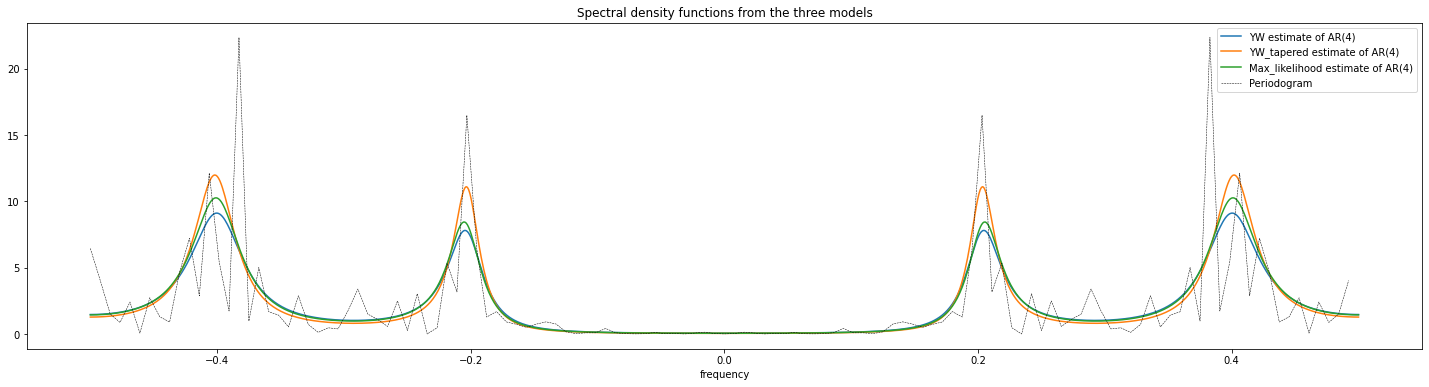

In [18]:
f = np.arange(-N/2, N/2)/N  # shifter Fourier frequencies
t = np.linspace(-1/2, 1/2, 1000)  
p = 4

plt.figure(figsize=(25, 6))

# plot the three estimated sdfs using S_ARMA
plt.plot(t, S_ARMA(t, YW(data, p)[0], [], YW(data, p)[1]), label = f"YW estimate of AR({p})")
plt.plot(t, S_ARMA(t, YW_tapered(data, p)[0], [], YW_tapered(data, p)[1]), label = f"YW_tapered estimate of AR({p})")
plt.plot(t, S_ARMA(t, max_likelihood(data, p)[0], [], max_likelihood(data, p)[1]), label = f"Max_likelihood estimate of AR({p})")

# we also plot the periodogram for reference
plt.plot(f, fftshift(periodogram(data)), "k--", linewidth = 0.5, label = "Periodogram")
plt.title("Spectral density functions from the three models")
plt.xlabel("frequency")
plt.legend()
plt.show()

Question 3

(a)



(b)